# Section 3_1 MLP networks


## Naive model from the last section

In [2]:
import dolfinx 
import torch

class model(torch.nn.Module):
    def __init__(self, device, dtype, dir= None):
        super().__init__()
        self.w = torch.nn.Parameter(torch.rand(8, device=device, dtype=dtype, requires_grad=True))
        if dir is not None:
            self.load_state_dict(torch.load(dir, weights_only=True))

    
    def forward(self, x):
        a = torch.sqrt(x[0]**2+x[1]**2)
        b = torch.sqrt(x[2]**2+x[3]**2)
        c = torch.sqrt(x[4]**2+x[5]**2)
        s = (a+b+c)/2
        A = torch.sqrt(s*((s-a)*(s-b)*(s-c)))
        h_K = 4*A/torch.sqrt(a**2+b**2+c**2)
        limit = h_K**2/(1e-8*48)
        low = torch.zeros_like(limit)
        z1 = torch.matmul(self.w, x)
        Pe = z1/(2*1e-8)
        z2 = z1/2*(1/torch.tanh(Pe)-(2*1e-8)*z1)
        supg_params = torch.clip(z2, min = low, max=limit)
        return supg_params

## creation of the dataset (target values)

```Python
from dolfinx import mesh as msh, fem, io, default_scalar_type
from mpi4py import MPI
import os
import torch
import numpy as np
import ufl
from mpi4py import MPI
import numpy as np
from utils.FEniCSx_solver import FEniCSx_solver
from utils.FEniCSx_PyTorch_interface import FEniCSx_PyTorch_interface

mean = 0


def mesh_to_x(mesh, cell_ind_to_grid, epsK, bK, cK, fK, non_perturbed=False, device=None, dtype=None):
    lst = []
    for v in mesh.geometry.x[:,0:2][mesh.geometry.dofmap]:
        xK = np.concat((v, epsK, bK, cK, fK), axis=None)
        lst.append(xK)

    xnp=np.array(lst).T
    x = torch.tensor(xnp[:,cell_ind_to_grid], requires_grad=False, device=device, dtype=dtype)

    x = torch.nn.functional.pad(x, pad=(1,1,1,1))

    # left column: set v0, v1 to v0, v1 of neighboring column
    x[0:4,1:ny+1, 0] = x[0:4,1:ny+1, 1]
    # set collapsed vertices v2 and v3 to v1 at the same position
    x[4:6,1:ny+1, 0] = x[2:3,1:ny+1, 0]
    x[6:8,1:ny+1, 0] = x[2:3,1:ny+1, 0]


    # right column: set v0 to v2 of neighboring column
    x[0:4,1:ny+1, -1] = x[4:8,1:ny+1, -1 -1]
    # set collapsed vertices v2 and v3 to v1 at the same position
    x[4:6,1:ny+1, -1] = x[2:3,1:ny+1, -1]
    x[6:8,1:ny+1, -1] = x[2:3,1:ny+1, -1]


    # top row: set v0 to v0 of neighboring row
    x[0:2,0,1:nx+1] = x[2:4,1,1:nx+1]
    # top row: set v1 to v3 of neighboring row
    x[2:4,0,1:nx+1] = x[6:8,1,1:nx+1]
    # set collapsed vertices v2 and v3 to v1 at the same position
    x[4:6,0,1:nx+1] = x[2:3,0,1:nx+1]
    x[6:8,0,1:nx+1] = x[2:3,0,1:nx+1]

    # bottom row: set v0 to v0 of neighboring row
    x[0:2,-1,1:nx+1] = x[0:2,-1-1,1:nx+1]
    # bottom row: set v1 to v2 of neighboring row
    x[2:4,-1,1:nx+1] = x[4:6,-1-1,1:nx+1]
    # set collapsed vertices v2 and v3 to v1 at the same position
    x[4:6,-1,1:nx+1] = x[2:3,-1,1:nx+1]
    x[6:8,-1,1:nx+1] = x[2:3,-1,1:nx+1]

    # set upper left corner to v0 of neigboring horizontal edge
    x[0:2,0,0] = x[0:2,0,1]
    # set remaining vertices to v0
    x[2:4,0,0] = x[0:2,0,0]
    x[4:6,0,0] = x[0:2,0,0]
    x[6:8,0,0] = x[0:2,0,0]

    # set bottom left corner to v0 of neighboring horizontal edge
    x[0:2,-1,0] = x[0:2,-1,1]
    # set remaining vertices to v0
    x[2:4,-1,0] = x[0:2,-1,0]
    x[4:6,-1,0] = x[0:2,-1,0]
    x[6:8,-1,0] = x[0:2,-1,0]

    # set upper right corner to v1 of neighboring horizontal edge
    x[0:2,0,-1] = x[2:4,0,-1-1]
    # set remaining vertices to v0
    x[2:4,0,-1] = x[0:2,0,-1]
    x[4:6,0,-1] = x[0:2,0,-1]
    x[6:8,0,-1] = x[0:2,0,-1]

    # set bottom right corner to v1 of neighboring horizontal edge
    x[0:2,-1,-1] = x[2:4,-1,-1-1]
    # set remaining vertices to v0
    x[2:4,-1,-1] = x[0:2,-1,-1]
    x[4:6,-1,-1] = x[0:2,-1,-1]
    x[6:8,-1,-1] = x[0:2,-1,-1]

    # set the dirichlet boundary condition
    x[11,0,:] = 1
    x[11,-1,:] = 1
    x[11,:,0] = 1
    x[11,:,-1] = 1

    if non_perturbed:
        if np.all(bK == np.array([1,0])):
            x[12,0,:] = (x[0,0,:] + x[2,0,:])/2
            x[12,-1,:] = (x[0,-1,:] + x[2,-1,:])/2
            x[12,:,0] = (x[0,:,0] + x[2,:,0])/2
            x[12,:,-1] = (x[0,:,-1] + x[2,:,-1])/2
        if np.all(bK == np.array([-1,0])):
            x[12,0,:] = ((x[0,0,:] + x[2,0,:])/2).flip(0)
            x[12,-1,:] = ((x[0,-1,:] + x[2,-1,:])/2).flip(0)
            x[12,:,0] = ((x[0,:,0] + x[2,:,0])/2).flip(0)
            x[12,:,-1] = ((x[0,:,-1] + x[2,:,-1])/2).flip(0)
        if np.all(bK == np.array([0,1])):
            x[12,0,:] = (x[1,0,:] + x[3,0,:])/2
            x[12,-1,:] = (x[1,-1,:] + x[3,-1,:])/2
            x[12,:,0] = (x[1,:,0] + x[3,:,0])/2
            x[12,:,-1] = (x[1,:,-1] + x[3,:,-1])/2
        if np.all(bK == np.array([0,-1])):
            x[12,0,:] = ((x[1,0,:] + x[3,0,:])/2).flip(0)
            x[12,-1,:] = ((x[1,-1,:] + x[3,-1,:])/2).flip(0)
            x[12,:,0] = ((x[1,:,0] + x[3,:,0])/2).flip(0)
            x[12,:,-1] = ((x[1,:,-1] + x[3,:,-1])/2).flip(0)


    return x

model_init='data/example_2_1/models/nn_init.pth'

nn= model(device='cpu', dtype=torch.float64, dir=model_init)
w = nn.state_dict()['w'].detach().numpy()

def create_target_values(mesh, bK, non_perturbed=False):
    Wh = fem.functionspace(mesh, ('P', 2))
    mesh.topology.create_connectivity(mesh.topology.dim - 1, mesh.topology.dim)
    boundary_facets = msh.exterior_facet_indices(mesh.topology)
    boundary_dofs = fem.locate_dofs_topological(Wh, mesh.topology.dim-1, boundary_facets)
    bcs = [fem.dirichletbc(fem.Constant(mesh, default_scalar_type(0.0)), boundary_dofs, Wh)]

    eps = fem.Constant(mesh, default_scalar_type(1e-8))

    b = ufl.as_vector((fem.Constant(mesh, default_scalar_type(bK[0])),fem.Constant(mesh, default_scalar_type(bK[1]))))
    f = fem.Constant(mesh, default_scalar_type(1.0))
    uh = fem.Function(Wh)

    x = ufl.SpatialCoordinate(mesh)
    if np.all(bK == np.array([1,0])) or np.all(bK == np.array([-1,0])):
        dir = 0
    else:
        dir = 1
    ex_exp = x[dir]*(1-ufl.exp(-(1-x[dir])/eps))* (1 - (((ufl.exp(-(1-x[(dir+1)%2])/eps)  + ufl.exp(-(x[(dir+1)%2])/eps)))- ufl.exp(-(1)/eps))/(1-ufl.exp(-1/eps)))

    if np.min(bK) < 0:
        ex_exp = (1-x[dir])*(1-ufl.exp(-(x[dir])/eps))* (1 - (((ufl.exp(-(1-x[(dir+1)%2])/eps)  + ufl.exp(-(x[(dir+1)%2])/eps)))- ufl.exp(-(1)/eps))/(1-ufl.exp(-1/eps)))


    if non_perturbed:
        ex_exp = x[dir]
    if np.min(bK) < 0:
        ex_exp = 1 - ex_exp
        
    exp = fem.Expression(ex_exp, Wh.element.interpolation_points())

    u_ex = fem.Function(Wh)
    u_ex.interpolate(exp)

    loss = (uh-u_ex)**2 * ufl.dx
    pde_data = mesh,Wh,uh,eps,b,None,f,None,bcs

    FEniCSx = FEniCSx_solver(pde_data=pde_data, loss_form=loss)

    lst = []
    bK = np.array([1,0])
    for v in mesh.geometry.x[:,0:2][mesh.geometry.dofmap]:
        xK = np.concat((v[2]-v[1], v[2]-v[0], v[1]-v[0], bK), axis=None)
        lst.append(xK)

    xnp=np.array(lst).T
    z1 = np.matmul(w, xnp)
    Pe = z1/(2*1e-8)
    supg_params = z1/2*(1/np.tanh(Pe)-(2*1e-8)*z1)

    FEniCSx.set_weights(supg_params)
    params = torch.tensor(supg_params, requires_grad=True)
    autograd_func = FEniCSx_PyTorch_interface.apply

    def fem_solver(weights):
        return autograd_func(weights, FEniCSx)

    optimizer = torch.optim.Adam([params])
    train_loss = 0
    for steps in range(iterations):
        optimizer.zero_grad()
        loss = fem_solver(params)
        loss.backward()
        # Backpropagation
        optimizer.step()

    train_loss += loss
    target = params
    return target



iterations = 500
comm = MPI.COMM_WORLD
epsK = 1e-8
cK = 0
fK = 1


num = 0

nx = 32
ny = 32
std = 1/(3*(nx+ny))

mesh = msh.create_unit_square(comm, nx, ny, msh.CellType.quadrilateral)
Yh = fem.functionspace(mesh, ('DG', 0))
pts = Yh.tabulate_dof_coordinates()
x = pts[:,0]
y = pts[:,1]
cell_ind_to_grid = np.lexsort((pts[:,0], -pts[:,1])).reshape(ny,nx)

vertices = mesh.geometry.x

cells = mesh.geometry.dofmap

element = mesh.geometry.cmap
mask= ~np.any((vertices[:,:2] == 0) | (vertices[:,:2] == 1), axis=1)
for bK in [np.array([1,0]), np.array([-1,0]), np.array([0,1]), np.array([0,-1])]:
    for non_perturbed in [True, False]:
        #with io.XDMFFile(mesh.comm, f"data/example_3_1/training_set/fem_data/mesh_{num}.xdmf", "w") as writer:
        #    writer.write_mesh(ms)
        x = mesh_to_x(mesh=mesh, cell_ind_to_grid=cell_ind_to_grid,epsK=epsK, bK=bK, cK=cK, fK=fK,non_perturbed=non_perturbed)
        torch.save(x, f'data/example_3_1/training_set/inputs/x_{num}.pt')
        t = create_target_values(mesh=mesh, bK=bK, non_perturbed=non_perturbed)
        torch.save(t, f'data/example_3_1/training_set/target_values/t_{num}.pt')
        num += 1

for i in range(50):
    for bK in [np.array([1,0]), np.array([-1,0]), np.array([0,1]), np.array([0,-1])]:
        for non_perturbed in [True, False]:
            noise = np.random.normal(mean, std, size=vertices.shape)
            noise[:,2] = 0
            new_vertices=vertices.copy()

            new_vertices[mask] += noise[mask]
            ms = msh.create_mesh(comm=comm, cells=cells, x=new_vertices, e=mesh.ufl_domain())
            
            #with io.XDMFFile(mesh.comm, f"data/example_3_1/training_set/fem_data/mesh_{num}.xdmf", "w") as writer:
            #    writer.write_mesh(ms)
            x = mesh_to_x(mesh=ms, cell_ind_to_grid=cell_ind_to_grid,epsK=epsK, bK=bK, cK=cK, fK=fK,non_perturbed=non_perturbed)
            torch.save(x, f'data/example_3_1/training_set/inputs/x_{num}.pt')
            t = create_target_values(mesh=ms, bK=bK, non_perturbed=non_perturbed)
            torch.save(t, f'data/example_3_1/training_set/target_values/t_{num}.pt')
            num += 1


num = 0

mesh = msh.create_unit_square(MPI.COMM_WORLD, nx, ny, msh.CellType.quadrilateral)

Yh = fem.functionspace(mesh, ('DG', 0))
pts = Yh.tabulate_dof_coordinates()
x = pts[:,0]
y = pts[:,1]
cell_ind_to_grid = np.lexsort((pts[:,0], -pts[:,1])).reshape(ny,nx)

vertices = mesh.geometry.x

cells = mesh.geometry.dofmap

element = mesh.geometry.cmap
mask= ~np.any((vertices[:,:2] == 0) | (vertices[:,:2] == 1), axis=1)
for i in range(20):
    for bK in [np.array([1,0]), np.array([-1,0]), np.array([0,1]), np.array([0,-1])]:
        for non_perturbed in [True, False]:
            noise = np.random.normal(mean, std, size=vertices.shape)
            noise[:,2] = 0
            new_vertices=vertices.copy()

            new_vertices[mask] += noise[mask]
            ms = msh.create_mesh(comm=comm, cells=cells, x=new_vertices, e=mesh.ufl_domain())
            #with io.XDMFFile(mesh.comm, f"data/example_3_1/training_set/fem_data/mesh_{num}.xdmf", "w") as writer:
            #    writer.write_mesh(ms)
            x = mesh_to_x(mesh=ms, cell_ind_to_grid=cell_ind_to_grid,epsK=epsK, bK=bK, cK=cK, fK=fK)
            torch.save(x, f'data/example_3_1/test_set/inputs/x_{num}.pt')
            t = create_target_values(mesh=ms, bK=bK, non_perturbed=non_perturbed)
            torch.save(t, f'data/example_3_1/test_set/target_values/t_{num}.pt')
            num += 1
```

## Global MLP modules

In [8]:
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

from utils.supervised_dataset import supervised_dataset as dataset
from torch.utils.data import DataLoader
from utils.transforms import flattening_transform, reindex_transform, create_cell_ind_to_grid, create_flattening_index_set



class resblock(nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer

    def forward(self, x):
        z = self.layer(x)
        return z+x

class MLP_block(nn.Module):
    def __init__(
            self, 
            insize, 
            outsize, 
            activation, 
            normalization=None, 
            residual_connection=None, 
            Dropout=None, 
            p=0.5
        ):
        super().__init__()
        self.residual_connection = residual_connection
        components = [nn.Linear(insize, outsize), activation()]
        if normalization:
            components.append(normalization(outsize))
        if Dropout:
            components.append(nn.Dropout(p=p))
        self.layer = nn.Sequential(*components)
        if residual_connection:
            self.layer = resblock(self.layer)

            
    def forward(self, x):
        return self.layer(x) 
    
class const_featuresize_MLP(nn.Module):
    def __init__(
            self, 
            width, 
            depth, 
            activation,
            residual_connection=False, 
            normalization=False, 
            Dropout=None, 
            p=0.5
        ):
        super().__init__()
        layers = []
        for _ in range(depth):
            layers.append(
                MLP_block(
                    insize=width, 
                    outsize=width, 
                    activation=activation, 
                    normalization=normalization, 
                    residual_connection=residual_connection, 
                    Dropout=Dropout, 
                    p=p
                )
            )
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

    


class sMLP(torch.nn.Module):
    def __init__(
            self, 
            in_features, 
            cdim_MLP_width, 
            cdim_MLP_depth, 
            out_features, 
            activation, 
            residual_connection=False, 
            normalization=False, 
            Dropout=False, 
            p=0.5, 
            dir=None
        ):
        super().__init__()
        if cdim_MLP_depth == 0:
            self.ffwd = nn.Sequential(
                MLP_block(
                    insize=in_features, 
                    outsize=out_features, 
                    activation=activation, 
                )
            )
        if cdim_MLP_depth == 1:
            self.ffwd = nn.Sequential(
                MLP_block(
                    insize=in_features, 
                    outsize=out_features, 
                    activation=activation, 
                    normalization=normalization, 
                    Dropout=Dropout, 
                    p=p
                ),
                const_featuresize_MLP(
                    width=out_features, 
                    depth=1, 
                    activation=activation, 
                    residual_connection=residual_connection
                )
            )
        else:
            self.ffwd = nn.Sequential(
                MLP_block(
                    insize=in_features, 
                    outsize=cdim_MLP_width, 
                    activation=activation, 
                    normalization=normalization, 
                    Dropout=Dropout, 
                    p=p
                ),
                const_featuresize_MLP(
                    width=cdim_MLP_width, 
                    depth=cdim_MLP_depth, 
                    activation=activation, 
                    residual_connection=residual_connection, 
                    normalization=normalization, 
                    Dropout=Dropout, 
                    p=p
                ),
                MLP_block(
                    insize=cdim_MLP_width, 
                    outsize=out_features, 
                    activation=activation, 
                )
        )
        if dir:
            self.load_state_dict(torch.load(dir, weights_only=True))

    def forward(self, x):
        y_pred = self.ffwd(x)
        return y_pred



## Global MLP datasets and training loops

In [7]:
def train_loop(dataloader, nn, optimizer, loss_fn):
    num_batches = len(dataloader)
    nn.train()
    train_loss = 0.0
    for batch, (x, t) in enumerate(dataloader):
        y_pred = nn(x)

        loss = loss_fn(y_pred,t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= num_batches
    print(f"Train loss: {train_loss:>7f}")
    return(train_loss)

def test_loop(dataloader, nn, loss_fn):
    nn.eval()
    num_batches = len(dataloader)
    test_loss = 0.0

    with torch.no_grad():
        for x, t in dataloader:
            y_pred = nn(x)

            loss = loss_fn(y_pred,t)

            test_loss += loss.item()

    test_loss /= num_batches
    print(f"Test loss: {test_loss:>8f} \n")
    return(test_loss)


def train(
        device,
        dtype,
        model_init_dir,
        in_features,
        width,
        depth,
        out_features,
        activation,
        residual_connection,
        normalization,
        Dropout,
        p,
        loss_fn,
        optimizer, 
        scheduler,
        step_size,
        epochs, 
        train_set_input_dir,
        train_set_target_dir,
        test_set_input_dir,
        test_set_target_dir,
        batch_size,
        save_steps = 10,
        train_loss_file = None, 
        test_loss_file = None,
        model_dir = None,
        figure = None,
        figure_file = None
):
    H,W = 32,32
    transform_flat_key = create_flattening_index_set(H=H+2,W=W+2, continuous_traversal=False)
    transform = flattening_transform(flat_key=transform_flat_key, C=13)
    train_set = dataset(
        input_dir=train_set_input_dir, 
        target_dir=train_set_target_dir, 
        transform=transform, 
        target_transform=None, 
        device=device
    )

    test_set = dataset(
        input_dir=test_set_input_dir, 
        target_dir=test_set_target_dir, 
        transform=transform, 
        target_transform=None, 
        device=device
    )
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    try:
        model = sMLP(
            in_features=in_features, 
            out_features=out_features, 
            activation=activation, 
            cdim_MLP_width=width,
            cdim_MLP_depth=depth, 
            residual_connection=residual_connection, 
            normalization=normalization,
            Dropout=Dropout,
            p=p,
            dir=model_init_dir
        ).to(
            device=device, 
            dtype=dtype
        )
    except:
        model = sMLP(
            in_features=in_features, 
            out_features=out_features, 
            activation=activation, 
            cdim_MLP_width=width,
            cdim_MLP_depth=depth, 
            residual_connection=residual_connection, 
            normalization=normalization,
            dir=None
        ).to(
            device=device, 
            dtype=dtype
        )
        torch.save(model.state_dict(), model_init_dir)
    optimizer = optimizer(model.parameters())
    scheduler = scheduler(optimizer=optimizer, step_size=step_size)
    train_loss_array = np.array([])
    test_loss_array = np.array([])
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss_array = np.append(
            train_loss_array, 
            train_loop(
                dataloader=train_loader,
                nn=model,
                optimizer=optimizer,
                loss_fn=loss_fn
                )
        )
        scheduler.step()
        if model_dir and t%save_steps==0:
            torch.save(nn.state_dict(), f'{model_dir}_{t}.pth')
        test_loss_array = np.append(
            test_loss_array,
            test_loop(
                dataloader=test_loader, 
                nn=model, 
                loss_fn=loss_fn
            )
        )
    if train_loss_file:
        np.save(file=train_loss_file, arr=train_loss_array)
    if test_loss_file:
        np.save(file=test_loss_file, arr=test_loss_array)
    if figure:
        clear_output()
        x= np.linspace(1,len(train_loss_array),len(train_loss_array))

        plt.plot(x, train_loss_array, label= 'Train loss', linestyle='-',)
        plt.plot(x, test_loss_array,label='Test loss', linestyle='-')

        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.grid(True)
        if figure_file:
            plt.savefig(figure_file)
        plt.show()
    return train_loss_array, test_loss_array

In [11]:
import os
import torch


train_set_input_dir = 'data/example_3_1/training_set/inputs/',
train_set_target_dir = "data/example_3_1/training_set/target_values/",
test_set_input_dir = "data/example_3_1/test_set/inputs/",
test_set_target_dir = "data/example_3_1/test_set/target_values/",
device = 'cpu'

train_set = dataset(
    input_dir=train_set_input_dir[0], 
    target_dir=train_set_target_dir[0], 
    transform=None, 
    target_transform=None, 
    device=device
)

test_set = dataset(
    input_dir=test_set_input_dir[0], 
    target_dir=test_set_target_dir[0], 
    transform=None, 
    target_transform=None, 
    device=device
)



def reassign_dtypes(set, dtype):
    for idx in range(len(set)):
        input_path = os.path.join(set.input_dir, f"x_{idx}.pt")
        input = torch.load(input_path) 

        target_path = os.path.join(set.target_dir, f"t_{idx}.pt")
        target = torch.load(target_path) 

        x = input.to(torch.float32)
        torch.save(x, input_path)
        t = target.to(torch.float32)
        torch.save(t, target_path)
reassign_dtypes(train_set, torch.float32)
reassign_dtypes(test_set, torch.float32)

## Different network configurations

In [ ]:


train_loss_d1_plain, test_loss_d1_plain, = train(
    device = 'mps',
    dtype = torch.float32,
    model_init_dir = f"data/example_3_1/models/d1_plain_model_init.pth",
    in_features = 15028,
    out_features = 1024,
    width=2000,
    depth = 0,
    activation = nn.LeakyReLU,
    residual_connection = None,
    normalization = None,
    Dropout = None,
    p = None,
    loss_fn = nn.MSELoss(),
    optimizer = torch.optim.Adam, 
    scheduler = torch.optim.lr_scheduler.StepLR,
    step_size = 10,
    epochs = 20, 
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size = 10,
    save_steps = 10,
    train_loss_file = None, 
    test_loss_file = None,
    model_dir = None,
    figure = False,
    figure_file = None
)

train_loss_d4_plain, test_loss_d4_plain, = train(
    device = 'mps',
    dtype = torch.float32,
    model_init_dir = f"data/example_3_1/models/d4_plain_model_init.pth",
    in_features = 15028,
    out_features = 1024,
    width=2000,
    depth = 3,
    activation = nn.LeakyReLU,
    residual_connection = None,
    normalization = None,
    Dropout = None,
    p = None,
    loss_fn = nn.MSELoss(),
    optimizer = torch.optim.Adam, 
    scheduler = torch.optim.lr_scheduler.StepLR,
    step_size = 10,
    epochs = 20, 
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size = 10,
    save_steps = 10,
    train_loss_file = None, 
    test_loss_file = None,
    model_dir = None,
    figure = False,
    figure_file = None
)

train_loss_d6_plain, test_loss_d6_plain, = train(
    device = 'mps',
    dtype = torch.float32,
    model_init_dir = f"data/example_3_1/models/d6_plain_model_init.pth",
    in_features = 15028,
    out_features = 1024,
    width=2000,
    depth = 5,
    activation = nn.LeakyReLU,
    residual_connection = None,
    normalization = None,
    Dropout = None,
    p = None,
    loss_fn = nn.MSELoss(),
    optimizer = torch.optim.Adam, 
    scheduler = torch.optim.lr_scheduler.StepLR,
    step_size = 10,
    epochs = 20, 
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size = 10,
    save_steps = 10,
    train_loss_file = None, 
    test_loss_file = None,
    model_dir = None,
    figure = False,
    figure_file = None
)

## Visualization of the loss values

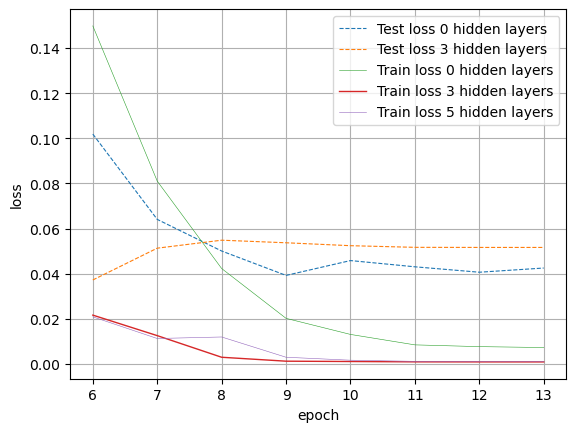

In [242]:
start = 5
end = 13
x= np.linspace(start+1,end,len(train_loss_d1_plain[start:end]))


plt.plot(x, test_loss_d1_plain[start:end], label= 'Test loss 0 hidden layers', linestyle='--', linewidth=0.8)
plt.plot(x, test_loss_d4_plain[start:end],label='Test loss 3 hidden layers', linestyle='--', linewidth=0.8)
plt.plot(x, train_loss_d1_plain[start:end], label= 'Train loss 0 hidden layers', linestyle='-', linewidth=0.4)
plt.plot(x, train_loss_d4_plain[start:end], label= 'Train loss 3 hidden layers', linestyle='-', linewidth=1)
plt.plot(x, train_loss_d6_plain[start:end], label= 'Train loss 5 hidden layers', linestyle='-', linewidth=0.4)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.savefig('example_3_1_plain_loss.png')
plt.show()

## Deep network

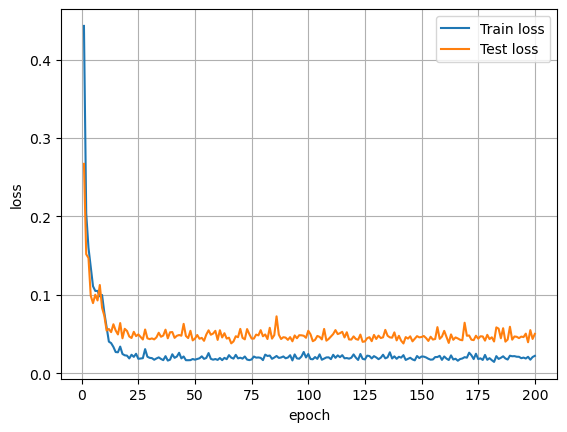

In [182]:

train_loss_d10_batch_res_dropout, test_loss_d10_batch_res_dropout, = train(
    device = 'mps',
    dtype = torch.float32,
    model_init_dir = f"data/example_3_1/models/d6_plain_model_init.pth",
    in_features = 15028,
    out_features = 1024,
    width=1024,
    depth = 10,
    activation = nn.LeakyReLU,
    residual_connection = True,
    normalization = nn.BatchNorm1d,
    Dropout = True,
    p = None,
    loss_fn = nn.MSELoss(),
    optimizer = torch.optim.Adam, 
    scheduler = torch.optim.lr_scheduler.StepLR,
    step_size = 10,
    epochs = 200, 
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size = 10,
    save_steps = 10,
    train_loss_file = None, 
    test_loss_file = None,
    model_dir = None,
    figure = True,
    figure_file = None
)

### Models with narrow layers

In [ ]:
train_loss_d4_w2, test_loss_d4_w2, = train(
    device = 'mps',
    dtype = torch.float32,
    model_init_dir = f"data/example_3_1/models/d4_w2_model_init.pth",
    in_features = 15028,
    out_features = 1024,
    width= 25,
    depth = 4,
    activation = nn.LeakyReLU,
    residual_connection = False,
    normalization = None,
    Dropout = False,
    p = None,
    loss_fn = nn.MSELoss(),
    optimizer = torch.optim.Adam, 
    scheduler = torch.optim.lr_scheduler.StepLR,
    step_size = 10,
    epochs = 40, 
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size = 15,
    save_steps = 10,
    train_loss_file = None, 
    test_loss_file = None,
    model_dir = None,
    figure = False,
    figure_file = None
)

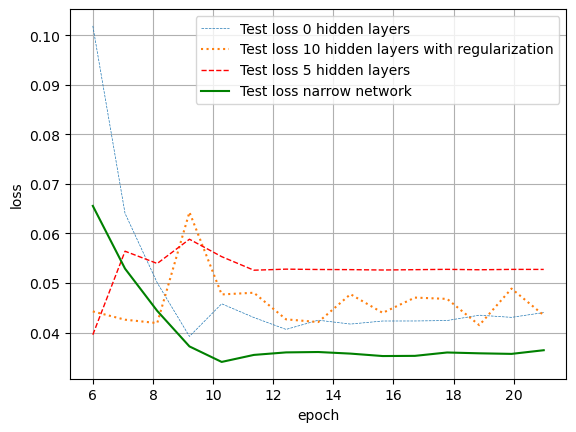

In [251]:
start = 5
end = 20
x= np.linspace(start+1,end+1,len(test_loss_d4_w2[start:end]))


plt.plot(x, test_loss_d1_plain[start:end],label='Test loss 0 hidden layers', linestyle='--', linewidth=0.5)
plt.plot(x, test_loss_d10_batch_res_dropout[start+160:end+160],label='Test loss 10 hidden layers with regularization', linestyle=':')
plt.plot(x, test_loss_d6_plain[start:end],label='Test loss 5 hidden layers', linestyle='--', linewidth=1, color='red')
plt.plot(x, test_loss_d4_w2[start:end],label='Test loss narrow network', linestyle='-', linewidth=1.5, color='green')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.savefig('example_3_1_narrow_model_loss.png')
plt.show()

## Average loss values

In [ ]:
a = np.average(train_loss_d1_plain[-1-10:-1])

b = np.average(train_loss_d4_w2[-1-10:-1])

c = np.average(train_loss_d10_batch_res_dropout[-1-10:-1])

d = np.average(test_loss_d1_plain[-1-10:-1])

e = np.average(test_loss_d4_w2[-1-10:-1])

f = np.average(test_loss_d10_batch_res_dropout[-1-10:-1])

print(f" train single-layer: {a}\n train narrow nn: {b}\n train deep nn: {c}\n test single-layer: {a}\n test narrow nn: {e}\n test deep nn: {f}")

 train single-layer: 0.007438941978815399
 train narrow nn: 0.02052657182960372
 train deep nn: 0.020102706869564405
 test single-layer: 0.007438941978815399
 test narrow nn: 0.03576281930065967
 test deep nn: 0.04613562466111034


In [259]:
g

4.807514214051534